In [4]:
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import transforms
import numpy as np

import sys
sys.path.append(r"D:\Facultate-an-3-semestrul-2\pytorch-licenseplate-segmentation")
from model import create_model
import utils

In [17]:
def show_images(images, cols=1, prefix='Image ', titles=None):
    # https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None:
        titles = [f'{prefix} ({i})' for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(int(cols), int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    
def plot(img, pred, threshold=0.5):
    plt.figure(figsize=(20,20));
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(pred.cpu().numpy()[0]>threshold)
    plt.title('Segmentation Output')
    plt.axis('off')

def pred(image, model):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
        return output

In [12]:
model = create_model()
checkpoint = torch.load(r'D:\Facultate-an-3-semestrul-2\LPDR-parking-system\models\model_v2.pth', map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

if torch.cuda.is_available():
    model.to('cuda')

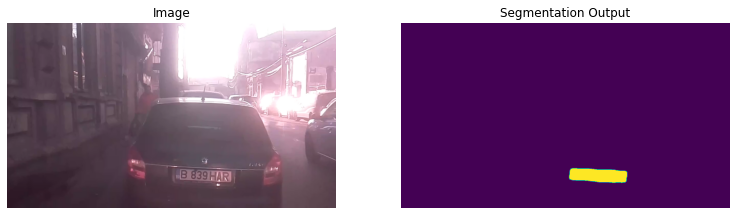

In [27]:
image = Image.open(r'D:\Facultate-an-3-semestrul-2\LPDR-parking-system\Dataset\train\images\lpdr_sample_267.jpg').convert('RGB')
outputs = pred(image=image, model=model)
plot(image, outputs, threshold=0.1)

mask = outputs.cpu().numpy()[0]>0.1
mask = mask.astype(np.uint8)

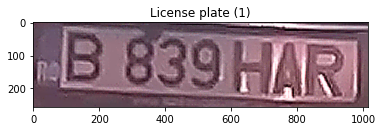

In [28]:
license_plates = utils.extract_segmentation_results(image, mask, sharpen_amount=50)
show_images(license_plates, prefix='License plate')